In [1]:
import numpy as np
import tensorflow as tf
import re
import tqdm

D:\Anaconda\lib\site-packages\h5py\__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
# 替换一些字符，所有字母变为小写
def clean_str(string):
    """
    Tokenization/string cleaning for all datasets except for SST.
    Original taken from https://github.com/yoonkim/CNN_sentence/blob/master/process_data.py
    """
    string = re.sub(r"[^A-Za-z0-9(),!?\'\`]", " ", string)
    string = re.sub(r"\'s", " \'s", string)
    string = re.sub(r"\'ve", " \'ve", string)
    string = re.sub(r"n\'t", " n\'t", string)
    string = re.sub(r"\'re", " \'re", string)
    string = re.sub(r"\'d", " \'d", string)
    string = re.sub(r"\'ll", " \'ll", string)
    string = re.sub(r",", " , ", string)
    string = re.sub(r"!", " ! ", string)
    string = re.sub(r"\(", " \( ", string)
    string = re.sub(r"\)", " \) ", string)
    string = re.sub(r"\?", " \? ", string)
    string = re.sub(r"\s{2,}", " ", string)
    return string.strip().lower()

In [3]:
# 加载数据，并对数据做处理
def load_data(pos_data, neg_data):
    # 读入样本，将样本放入list中
    pos = list(open(pos_data, "r", encoding='utf-8').readlines())
    # strip()移除字符串头尾指定的字符（默认为空格或换行符）或字符序列
    pos = [s.strip() for s in pos]
    
    neg = list(open(neg_data, "r", encoding='utf-8').readlines())
    neg = [s.strip() for s in neg]

    x = pos + neg
    x = [clean_str(_) for _ in x]
    x = np.array(x)
    
    pos_label = [[0] for _ in pos]
    neg_label = [[1] for _ in neg]
    
    y = np.concatenate([pos_label, neg_label], axis=0) # axis=0 按行拼接
    y = np.array(y)
    # y = tf.concat(0, [pos_label, neg_label]) 也可以这样写 与上一行作用相同
    return [x, y]

In [4]:
print("加载数据ing...")
x, y = load_data("data/pos.txt", "data/neg.txt")

# 查看数据
print("评价平均长度: {}".format(np.mean([len(sentence.split()) for sentence in x])))
max_document_length = max([len(_.split(" ")) for _ in x]) # 找到最长的句子
print("最长的评价长度：{}".format(max_document_length))
min_document_length = min([len(_.split(" ")) for _ in x]) # 找到最长的句子
print("最短的评价长度：{}".format(min_document_length))

print(x.shape)
print(y.shape)

加载数据ing...
评价平均长度: 20.38585631213656
最长的评价长度：56
最短的评价长度：1
(10662,)
(10662, 1)


In [5]:
# 设置评价最大长度
TEXT_MAX_SIZE = 30

In [6]:
# 建立词典 key为单词 value为出现次数
voc_dic = {}
for sentence in x:
    words = sentence.split()
    for word in words:
        if word in voc_dic:
            voc_dic[word] += 1
        else:
            voc_dic[word] = 1

In [7]:
# 构建词表
vocab = ["<pad>", "<unk>"]

# 词频大于1的才加入词表
for k, v in voc_dic.items():
    if v > 1:
        vocab.append(k)

print('词典长度：{}'.format(len(vocab)))

词典长度：10112


In [8]:
# 构建单词到索引的映射(每个数字代表一个单词或一个符号)
word_to_index = {word: index for index, word in enumerate(vocab)}

# 索引到单词的映射：
index_to_word = {index: word for index, word in enumerate(vocab)}

In [9]:
# 定义一个将句子中每个word转换为index的函数：
def sentence_to_index(sentence, max_size=TEXT_MAX_SIZE, word_map=word_to_index):
    # unknown和pad的index
    unk_id = word_map["<unk>"]
    pad_id = word_map["<pad>"]
    
    # 转换
    sentence_index = [word_map.get(word, unk_id) for word in sentence.lower().split()]
    
    # 长度小于给定长度时，填充；长度大于给定长度时，截断。
    if len(sentence_index) < max_size:
        sentence_index.extend([0] * (max_size - len(sentence_index)))
    else:
        sentence_index = sentence_index[:max_size]
    
    return sentence_index

In [10]:
s = "I like this move very much ！ 。 / ， 。"
a = sentence_to_index(s)
print(a)

[328, 65, 144, 311, 1037, 180, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


In [11]:
# 所有训练样本 转化为索引格式
x_index = []
for _ in x:
    single_index = sentence_to_index(_)
    x_index.append(single_index)
x_index = np.array(x_index)
x_index.shape

(10662, 30)

In [12]:
with open("data/glove.6B.300d.txt", "r", encoding = "utf-8") as f:
    word_to_vec = {}
    i = 0
    for line in tqdm.tqdm(f):
        line = line.split()
        word_to_vec[line[0]] = np.array(line[1:], dtype=np.float32)

400000it [00:40, 9790.64it/s] 


In [13]:
# 词表大小、embedding深度
VOCAB_SIZE = len(vocab)
EMBEDDING_SIZE = 300
VOCAB_SIZE

10112

In [14]:
# 初始化词向量矩阵，尺寸为 词表大小×embedding深度
original_embeddings = np.zeros([VOCAB_SIZE, EMBEDDING_SIZE])

for word, index in word_to_index.items():
    # 用glove词向量填充矩阵，如果glove中没有该词，则随机给个数
    word_vec = word_to_vec.get(word, np.random.randn(EMBEDDING_SIZE) * np.sqrt(2/EMBEDDING_SIZE))
    # 词向量矩阵中行号就是词的index值，每个词用300个数表示
    original_embeddings[index, :] = word_vec

# 将pad的300个数全设为0
original_embeddings[word_to_index["<pad>"], :] = 0

original_embeddings = original_embeddings.astype(np.float32)

In [15]:
# 分出训练集和测试集
def generate_train_test(x, y, train_ratio=0.8, shuffle=True):
    
    assert x.shape[0] == y.shape[0], print("error shape!")
    
    if shuffle:
        # permutation函数：打乱顺序
        shuffle_indices = np.random.permutation(range(x.shape[0]))
        x = x[shuffle_indices]
        y = y[shuffle_indices]
        
    # 从样本中分出训练集和测试集
    train_size = int(x.shape[0] * train_ratio)
    x_train = x[:train_size]
    y_train = y[:train_size]
    x_test = x[train_size:]
    y_test = y[train_size:]
    
    return x_train, y_train, x_test, y_test

In [16]:
x_train, y_train, x_test, y_test = generate_train_test(np.array(x_index), np.array(y))
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(8529, 30)
(8529, 1)
(2133, 30)
(2133, 1)


In [17]:
# 重置默认图
tf.reset_default_graph()

# 定义超参数
HIDDEN_SIZE = 512
LEARNING_RATE = 0.001
KEEP_PROB = 0.5
EPOCHES = 50
BATCH_SIZE = 256

In [18]:
# 分出mini_batch
def get_batch(x, y, batch_size=BATCH_SIZE, shuffle=True):
    
    assert x.shape[0] ==y.shape[0], print("error shape!")
    
    batches = []
    
    # 打乱顺序
    if shuffle:
        shuffle_indices = np.random.permutation(range(x.shape[0]))
        x = x[shuffle_indices]
        y = y[shuffle_indices]
    
    # batch数目（整数），如果剩下的样本不够一个batch，那在下面处理剩下的一部分
    batch_complete_num = int(x.shape[0] / batch_size)
    
    # 整数部分
    for k in range(batch_complete_num):
        batch_x = x[k*batch_size : (k+1)*batch_size, :] # 从k*batch_size到(k+1)*batch_size行,:代表所有列，
        batch_y = y[k*batch_size : (k+1)*batch_size, :]
        batch = (batch_x, batch_y)
        batches.append(batch)
    # 剩余部分
    if x.shape[0] % batch_size != 0:
        batch_x = x[batch_complete_num*batch_size : x.shape[0]]
        batch_y = y[batch_complete_num*batch_size : y.shape[0]]
        batch = (batch_x, batch_y)
        batches.append(batch)
    return batches

In [19]:
with tf.name_scope("rnn"):
    # placeholders
    with tf.name_scope("placeholders"):
        inputs = tf.placeholder(dtype=tf.int32, shape=(None, 30), name="inputs")
        targets = tf.placeholder(dtype=tf.float32, shape=(None, 1), name="targets")
    
    # embeddings
    with tf.name_scope("embeddings"):
        embedding_matrix = tf.Variable(initial_value=original_embeddings, trainable=False, name="embedding_matrix")
        embed = tf.nn.embedding_lookup(embedding_matrix, inputs, name="embed")
    
    # model
    with tf.name_scope("mode"):
        # 构造lstm单元
        lstm11 = tf.contrib.rnn.LSTMCell(HIDDEN_SIZE, initializer=tf.random_uniform_initializer(-0.1, 0.1, seed=123))
        # 添加dropout
        drop_lstm11 = tf.contrib.rnn.DropoutWrapper(lstm11, output_keep_prob=KEEP_PROB)
        _, lstm_state11 = tf.nn.dynamic_rnn(drop_lstm11, embed, dtype=tf.float32)
        
        # 输出层权重
        W = tf.Variable(tf.truncated_normal((HIDDEN_SIZE, 1), mean=0.0, stddev=0.1), name="W")
        b = tf.Variable(tf.zeros(1), name="b")
        
        logits = tf.add(tf.matmul(lstm_state11.h, W), b)
        outputs = tf.nn.sigmoid(logits, name="outputs")
        
        loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(labels=targets, logits=logits))
    
    # optimizer
    with tf.name_scope("optimizer"):
        optimizer = tf.train.AdamOptimizer(LEARNING_RATE).minimize(loss)
    
    # evaluation
    with tf.name_scope("evaluation"):
        correct_preds = tf.equal(tf.cast(tf.greater(outputs, 0.5), tf.float32), targets)
        accuracy = tf.reduce_sum(tf.reduce_sum(tf.cast(correct_preds, tf.float32), axis=1))

In [20]:
# 存储准确率
rnn_train_accuracy = []
rnn_test_accuracy = []

In [21]:
saver = tf.train.Saver()

In [22]:
config = tf.ConfigProto(allow_soft_placement=True, 
                        log_device_placement=True)
config.gpu_options.allow_growth=True

with tf.Session(config=config) as sess:
    sess.run(tf.global_variables_initializer())
    
    writer = tf.summary.FileWriter("./graphs/rnn", tf.get_default_graph())
    n_batches = int(x_train.shape[0] / BATCH_SIZE)
    
    for epoch in range(EPOCHES):
        total_loss = 0
        for x_batch, y_batch in get_batch(x_train, y_train):
            _, l = sess.run([optimizer, loss],
                            feed_dict={inputs: x_batch, 
                                       targets: y_batch})
            total_loss += l
        
        train_corrects = sess.run(accuracy, feed_dict={inputs: x_train, targets: y_train})
        train_acc = train_corrects / x_train.shape[0]
        rnn_train_accuracy.append(train_acc)

        test_corrects = sess.run(accuracy, feed_dict={inputs: x_test, targets: y_test})
        test_acc = test_corrects / x_test.shape[0]
        rnn_test_accuracy.append(test_acc)

        
        print("Training epoch: {}, Train loss: {:.4f}, Train accuracy: {:.4f}, Test accuracy: {:.4f}".format(epoch + 1, 
                                                                                                             total_loss / n_batches,
                                                                                                             train_acc,
                                                                                                             test_acc))
    
    saver.save(sess, "checkpoints/rnn")
    writer.close()

Training epoch: 1, Train loss: 0.6892, Train accuracy: 0.7142, Test accuracy: 0.7107
Training epoch: 2, Train loss: 0.5255, Train accuracy: 0.7830, Test accuracy: 0.7675
Training epoch: 3, Train loss: 0.4839, Train accuracy: 0.7847, Test accuracy: 0.7464
Training epoch: 4, Train loss: 0.4391, Train accuracy: 0.8102, Test accuracy: 0.7675
Training epoch: 5, Train loss: 0.3986, Train accuracy: 0.8488, Test accuracy: 0.7642
Training epoch: 6, Train loss: 0.3608, Train accuracy: 0.8695, Test accuracy: 0.7675
Training epoch: 7, Train loss: 0.3262, Train accuracy: 0.9084, Test accuracy: 0.7806
Training epoch: 8, Train loss: 0.2975, Train accuracy: 0.9166, Test accuracy: 0.7764
Training epoch: 9, Train loss: 0.2163, Train accuracy: 0.9263, Test accuracy: 0.7473
Training epoch: 10, Train loss: 0.1941, Train accuracy: 0.9373, Test accuracy: 0.7576
Training epoch: 11, Train loss: 0.1738, Train accuracy: 0.9436, Test accuracy: 0.7665
Training epoch: 12, Train loss: 0.1409, Train accuracy: 0.9733,

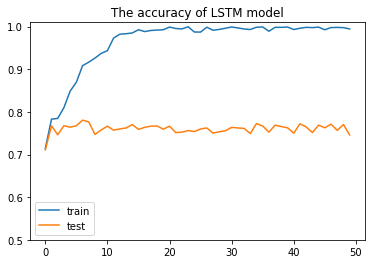

In [25]:
import matplotlib.pyplot as plt
plt.plot(rnn_train_accuracy)
plt.plot(rnn_test_accuracy)
plt.ylim(ymin=0.5, ymax=1.01)
plt.title("The accuracy of LSTM model")
plt.legend(["train", "test"])
plt.show()

In [26]:
# 在test上的准确率
with tf.Session() as sess:
    saver.restore(sess, "checkpoints/rnn")
    
    total_correct = sess.run(accuracy,
                             feed_dict={inputs: x_test, targets: y_test})

    print("The LSTM model accuracy on test set: {:.2f}%".format(100* total_correct / x_test.shape[0]))

INFO:tensorflow:Restoring parameters from checkpoints/rnn
The LSTM model accuracy on test set: 74.59%
